### Grab the dataset from kaggle using API
* mount the goole drive
* load the kaggle credentials into colab 
* download the dataset from kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp /content/drive/MyDrive/CapstoneAIML/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#https://www.kaggle.com/questions-and-answers/165032#1327573
from kaggle.api.kaggle_api_extended import KaggleApi
DS_PATH = "/content/dataset"
COMPETITION = "rsna-pneumonia-detection-challenge"
api = KaggleApi()
api.authenticate()
api.competition_download_files(COMPETITION, DS_PATH)

In [ ]:
!  unzip -oq /content/dataset/rsna-pneumonia-detection-challenge.zip -d /content/dataset

In [ ]:
!ls -l /content/dataset

total 3845324
-rw-r--r-- 1 root root         55 Dec 11  2019 'GCP Credits Request Link - RSNA.txt'
-rw-r--r-- 1 root root 3932287530 Mar 30 09:15  rsna-pneumonia-detection-challenge.zip
-rw-r--r-- 1 root root    1647396 Dec 11  2019  stage_2_detailed_class_info.csv
-rw-r--r-- 1 root root     159027 Dec 11  2019  stage_2_sample_submission.csv
drwxr-xr-x 2 root root     204800 Mar 30 09:15  stage_2_test_images
drwxr-xr-x 2 root root    1802240 Mar 30 09:16  stage_2_train_images
-rw-r--r-- 1 root root    1490034 Dec 11  2019  stage_2_train_labels.csv


### Necessary library imports 

In [ ]:
import os
import shutil
import time
import datetime

import pandas as pd
import numpy as np

import scipy.stats as stats

#%tensorflow_version 2.x
import tensorflow
print(tensorflow.__version__)

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import seaborn as sns

! pip install pydicom
import pydicom as dcm

from glob import glob

from tqdm import tqdm, notebook

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D
from tensorflow.keras.layers import Flatten, MaxPool2D, GlobalAvgPool2D
from tensorflow.keras.layers import Concatenate, ReLU, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

from skimage.transform import resize

2.8.0
     |████████████████████████████████| 2.0 MB 5.3 MB/s 


### Exploring stage_2_train_labels.csv

In [ ]:
train_labels = pd.read_csv(DS_PATH+'/stage_2_train_labels.csv')
train_labels.head(10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [ ]:
print('The train_labels dataframe has {} rows and {} columns.'.format(train_labels.shape[0], train_labels.shape[1]))
total_no_train_records = train_labels.shape[0]

The train_labels dataframe has 30227 rows and 6 columns.


In [ ]:
print('Number of unique patientId are: {}'.format(train_labels['patientId'].nunique()))

Number of unique patientId are: 26684


In [ ]:
train_labels_boxes = train_labels[train_labels['Target'] == 1].groupby('patientId').size().to_frame('number_of_box').reset_index()
train_labels = train_labels.merge(train_labels_boxes, on = 'patientId', how = 'left')
train_labels.head(10)

,patientId,x,y,width,height,Target,number_of_box
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,NaN
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,NaN
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,NaN
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,NaN
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2.0
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,2.0
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,NaN
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,NaN
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,2.0
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,2.0


### Exploring stage_2_detailed_class_info.csv

In [ ]:
class_labels = pd.read_csv(DS_PATH+"/stage_2_detailed_class_info.csv")
class_labels.head(10)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
6,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,No Lung Opacity / Not Normal
8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity


In [ ]:
print('The class_label dataframe has {} rows and {} columns.'.format(class_labels.shape[0], class_labels.shape[1]))

The class_label dataframe has 30227 rows and 2 columns.


In [ ]:
print('Number of unique patientId are: {}'.format(class_labels['patientId'].nunique()))

Number of unique patientId are: 26684


### Merge both the dataset

In [ ]:
train_labels_updated = train_labels.merge(class_labels, on = 'patientId', how = 'left')
train_labels_updated.head(10)

,patientId,x,y,width,height,Target,number_of_box,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,NaN,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,NaN,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,NaN,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,NaN,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2.0,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2.0,Lung Opacity
6,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,2.0,Lung Opacity
7,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,2.0,Lung Opacity
8,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,NaN,No Lung Opacity / Not Normal
9,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,NaN,No Lung Opacity / Not Normal


In [ ]:
print('After merge, the dataset has {} rows and {} columns.'.format(train_labels_updated.shape[0], train_labels_updated.shape[1]))
print('After merge, the number of unique patientId are: {}.'.format(train_labels_updated['patientId'].nunique()))

After merge, the dataset has 37629 rows and 8 columns.
After merge, the number of unique patientId are: 26684.


### DICOM files and medical images

In [ ]:
print('Number of images in training images folders are: {}.'.format(len(os.listdir(DS_PATH+'/stage_2_train_images'))))

Number of images in training images folders are: 26684.


In [ ]:
training_image_path = DS_PATH+'/stage_2_train_images/'

images = pd.DataFrame({'path': glob(os.path.join(training_image_path, '*.dcm'))})
images['patientId'] = images['path'].map(lambda x:os.path.splitext(os.path.basename(x))[0])
print('Columns in the training images dataframe: {}'.format(list(images.columns)))

Columns in the training images dataframe: ['path', 'patientId']


In [ ]:
# Merging the images dataframe with training_data dataframe
training_data = train_labels_updated.merge(images, on = 'patientId', how = 'left')
print('After merging the two dataframe, the training_data has {} rows and {} columns.'.format(training_data.shape[0], training_data.shape[1]))

After merging the two dataframe, the training_data has 37629 rows and 9 columns.


In [ ]:
print('The training_data dataframe as of now stands like\n')
training_data.head()

The training_data dataframe as of now stands like



,patientId,x,y,width,height,Target,number_of_box,class,path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,NaN,No Lung Opacity / Not Normal,/content/dataset/stage_2_train_images/0004cfab...
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,NaN,No Lung Opacity / Not Normal,/content/dataset/stage_2_train_images/00313ee0...
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,NaN,No Lung Opacity / Not Normal,/content/dataset/stage_2_train_images/00322d4d...
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,NaN,Normal,/content/dataset/stage_2_train_images/003d8fa0...
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2.0,Lung Opacity,/content/dataset/stage_2_train_images/00436515...


In [ ]:
columns_to_add = ['Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition', 'ConversionType', 'Rows', 'Columns', 'PixelSpacing']

def parse_dicom_data(data_df, data_path):
  for col in columns_to_add:
    data_df[col] = None
  image_names = os.listdir(data_path)
  
  for i, img_name in notebook.tqdm(enumerate(image_names)):
    imagepath = os.path.join(data_path, img_name)
    data_img = dcm.read_file(imagepath)
    idx = (data_df['patientId'] == data_img.PatientID)
    data_df.loc[idx, 'Modality'] = data_img.Modality
    data_df.loc[idx, 'PatientAge'] = pd.to_numeric(data_img.PatientAge)
    data_df.loc[idx, 'PatientSex'] = data_img.PatientSex
    data_df.loc[idx, 'BodyPartExamined'] = data_img.BodyPartExamined
    data_df.loc[idx, 'ViewPosition'] = data_img.ViewPosition
    data_df.loc[idx, 'ConversionType'] = data_img.ConversionType
    data_df.loc[idx, 'Rows'] = data_img.Rows
    data_df.loc[idx, 'Columns'] = data_img.Columns
    data_df.loc[idx, 'PixelSpacing'] = str.format("{:4.3f}", data_img.PixelSpacing[0])

In [ ]:
parse_dicom_data(training_data, DS_PATH+'/stage_2_train_images/')

0it [00:00, ?it/s]

In [ ]:
print('So after parsing the information from the dicom images, our training_data dataframe has {} rows and {} columns and it looks like:\n'.format(training_data.shape[0], training_data.shape[1]))
training_data.head()

So after parsing the information from the dicom images, our training_data dataframe has 37629 rows and 18 columns and it looks like:



,patientId,x,y,width,height,Target,number_of_box,class,path,Modality,PatientAge,PatientSex,BodyPartExamined,ViewPosition,ConversionType,Rows,Columns,PixelSpacing
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,NaN,No Lung Opacity / Not Normal,/content/dataset/stage_2_train_images/0004cfab...,CR,51,F,CHEST,PA,WSD,1024,1024,0.143
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,NaN,No Lung Opacity / Not Normal,/content/dataset/stage_2_train_images/00313ee0...,CR,48,F,CHEST,PA,WSD,1024,1024,0.194
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,NaN,No Lung Opacity / Not Normal,/content/dataset/stage_2_train_images/00322d4d...,CR,19,M,CHEST,AP,WSD,1024,1024,0.168
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,NaN,Normal,/content/dataset/stage_2_train_images/003d8fa0...,CR,28,M,CHEST,PA,WSD,1024,1024,0.143
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2.0,Lung Opacity,/content/dataset/stage_2_train_images/00436515...,CR,32,F,CHEST,AP,WSD,1024,1024,0.139


### VGG19 Model build, train & test

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

In [ ]:
training_data.shape[0]

37629

In [ ]:
SAMPLE_DATA = 1000
IMG_PATH = DS_PATH+'/data/'
training_data_images = training_data[['path','patientId','Target']]
try:
    shutil.rmtree(IMG_PATH, ignore_errors=False, onerror=None)
    print("Directory '% s' has been removed successfully" % IMG_PATH)
except Exception as error:
    print(error)
    print("Directory '% s' can not be removed" % IMG_PATH)

training_data_images = training_data_images[:SAMPLE_DATA] # to fasttrack the process

IMG_NORMAL_PATH = IMG_PATH + '/normal/'
if not os.path.exists(IMG_NORMAL_PATH):
  os.makedirs(IMG_NORMAL_PATH)

IMG_PNEMONIA_PATH = IMG_PATH + '/phenomina/'
if not os.path.exists(IMG_PNEMONIA_PATH):
  os.makedirs(IMG_PNEMONIA_PATH)


normal_images = training_data_images[training_data_images['Target']==0] 
for _,row in tqdm(normal_images.iterrows()):
    img=dcm.read_file(row['path']).pixel_array
    # img=resize(img,(256,256))
    plt.imsave(IMG_NORMAL_PATH + row['patientId']+'.jpg',img,cmap='gray')

phnemonia_images = training_data_images[training_data_images['Target']==1]
for _,row in tqdm(phnemonia_images.iterrows()):
    img=dcm.read_file(row['path']).pixel_array
    # img=resize(img,(256,256))
    plt.imsave(IMG_PNEMONIA_PATH + row['patientId']+'.jpg',img,cmap='gray')

[Errno 2] No such file or directory: '/content/dataset/data/'
Directory '/content/dataset/data/' can not be removed


396it [00:34, 11.42it/s]
604it [00:34, 17.74it/s]


In [ ]:
datagen = ImageDataGenerator(rescale=1/255.0, validation_split=0.3) # with out transformation

# collect train and test data
training_images = datagen.flow_from_directory(IMG_PATH, color_mode='rgb', batch_size=128, class_mode='binary', subset='training')
validation_images = datagen.flow_from_directory(IMG_PATH, color_mode='rgb',batch_size=32, class_mode='binary', subset='validation')

Found 418 images belonging to 2 classes.
Found 178 images belonging to 2 classes.


In [ ]:
training_images.class_indices, validation_images.class_indices

({'normal': 0, 'phenomina': 1}, {'normal': 0, 'phenomina': 1})

In [ ]:
pre_trained_model = VGG19(input_shape = (256,256,3), 
                                include_top = False, 
                                weights = 'imagenet')
 

for layer in pre_trained_model.layers:
    layer.trainable = False

# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

80150528/80134624 [==============================] - 1s 0us/step
last layer output shape:  (None, 8, 8, 512)


In [ ]:
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,LeakyReLU,ReLU,GaussianDropout

In [ ]:
model = Flatten()(last_output)
model = Dense(1024)(model)
model=LeakyReLU(0.1)(model)
model=Dropout(0.25)(model)
model=BatchNormalization()(model)
model = Dense(1024)(model)
model=LeakyReLU(0.1)(model)
model=Dropout(0.25)(model)
model=BatchNormalization()(model)
model = Dense(1, activation='sigmoid')(model)

In [ ]:
from tensorflow.keras.models import Model

In [ ]:
fmodel = Model( pre_trained_model.input, model) 

fmodel.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
fmodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [ ]:
# Train model
fmodel.fit(training_images, epochs=50, validation_data=validation_images, verbose=1)

Epoch 1/50
4/4 [==============================] - 50s 7s/step - loss: 1.2153 - accuracy: 0.5718 - val_loss: 1.3628 - val_accuracy: 0.6629
Epoch 2/50
4/4 [==============================] - 12s 4s/step - loss: 0.8257 - accuracy: 0.6746 - val_loss: 3.1697 - val_accuracy: 0.6629
Epoch 3/50
4/4 [==============================] - 12s 4s/step - loss: 0.5904 - accuracy: 0.7632 - val_loss: 1.8690 - val_accuracy: 0.6685
Epoch 4/50
4/4 [==============================] - 13s 3s/step - loss: 0.6026 - accuracy: 0.7177 - val_loss: 2.8568 - val_accuracy: 0.6629
Epoch 5/50
4/4 [==============================] - 12s 4s/step - loss: 0.5682 - accuracy: 0.7943 - val_loss: 2.3985 - val_accuracy: 0.6685
Epoch 6/50
4/4 [==============================] - 12s 3s/step - loss: 0.5048 - accuracy: 0.8086 - val_loss: 1.2518 - val_accuracy: 0.7191
Epoch 7/50
4/4 [==============================] - 12s 3s/step - loss: 0.3943 - accuracy: 0.8469 - val_loss: 1.0669 - val_accuracy: 0.7416
Epoch 8/50
4/4 [==================

In [ ]:
fmodel.save(DS_PATH+'model_vgg19.h5')

<Figure size 2160x1440 with 0 Axes>

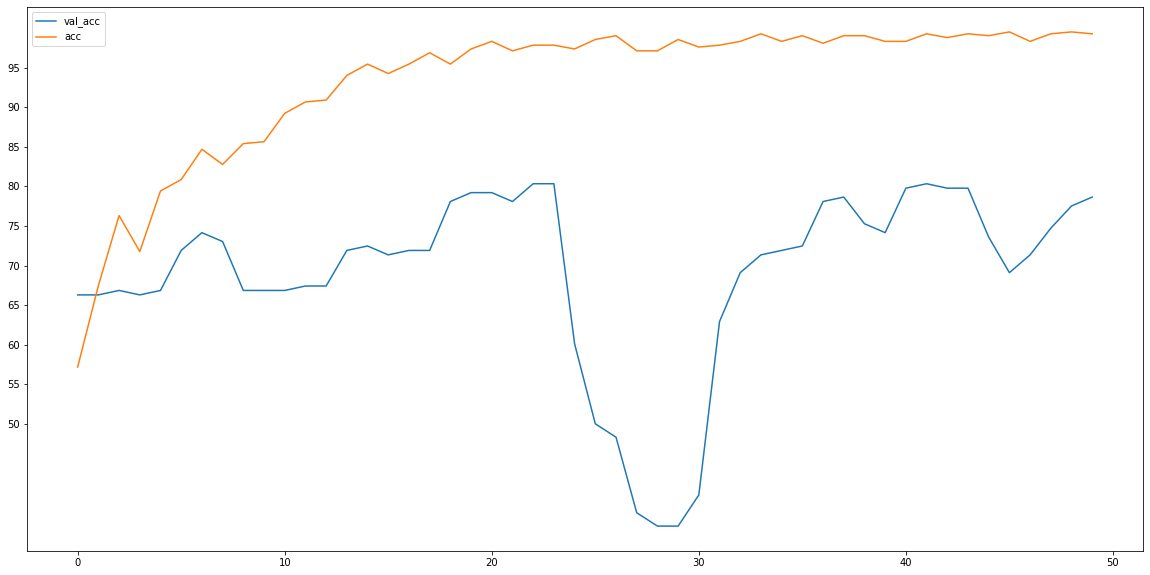

In [ ]:
## Plot accuracy
plt.figure(figsize=(30,20))
val_acc=np.asarray(fmodel.history.history['val_accuracy'])*100
acc=np.asarray(fmodel.history.history['accuracy'])*100
acc=pd.DataFrame({'val_acc':val_acc,'acc':acc})
acc.plot(figsize=(20,10),yticks=range(50,100,5))

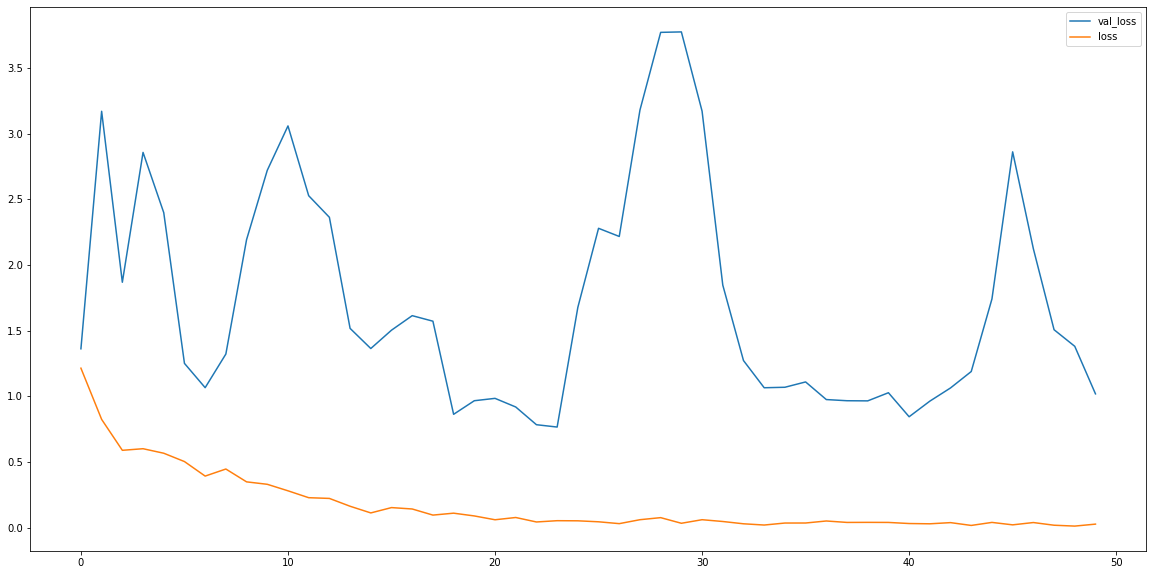

In [ ]:
# # Plot loss
loss=fmodel.history.history['loss']
val_loss=fmodel.history.history['val_loss']
loss=pd.DataFrame({'val_loss':val_loss,'loss':loss})
loss.plot(figsize=(20,10))